In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
tf.test.is_gpu_available()

False

In [3]:
vocab_size = 3500
embedding_dim = 128
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [4]:
import pandas as pd
df = pd.read_csv('cleaned.csv')

In [5]:
df = df.sample(frac=1)

In [6]:
X = df.keywords.values
y = df.label.values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

In [8]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [9]:
encoder.inverse_transform([0,1,2,3,4])

array(['gastroenterology', 'neurology', 'orthopedic', 'radiology',
       'urology'], dtype=object)

In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) #only train
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'of': 2,
 'and': 3,
 'ct': 4,
 'or': 5,
 'cervical': 6,
 'to': 7,
 'mri': 8,
 'sample': 9,
 'the': 10}

In [11]:
len(word_index)

3117

In [12]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train_padded[10]))
print('---')
print(X_train[10])

growth on the arm subluxing ulnar nerve collateral ligamentous complex common extensor tendon posteromedial aspect epimysial sheath extensor tendon tendon insertions ulnar nerve elbow edema olecranon inflammation nerve ulnar tendon ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
  growth on the arm  subluxing ulnar nerve  collateral ligamentous complex  common extensor tendon  posteromedial aspect  epimysial sheath  extensor tendon  tendon insertions  ulnar nerve  elbow  edema  olecranon  inflammation  nerve  ulnar  tendon


In [15]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = 150),
    #tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          448000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 744,709
Trainable params: 744,709
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
num_epochs = 10
history = model.fit(X_train_padded, y_train, epochs=num_epochs,
                    validation_split=0.1, verbose=1)

Train on 735 samples, validate on 82 samples
Epoch 1/10
735/735 [==============================] - 15s 21ms/sample - loss: 1.6031 - acc: 0.3728 - val_loss: 1.3531 - val_acc: 0.7073
Epoch 2/10
735/735 [==============================] - 13s 17ms/sample - loss: 0.9720 - acc: 0.7007 - val_loss: 0.7590 - val_acc: 0.8293
Epoch 3/10
735/735 [==============================] - 13s 17ms/sample - loss: 0.4164 - acc: 0.8993 - val_loss: 0.5332 - val_acc: 0.8171
Epoch 4/10
735/735 [==============================] - 13s 17ms/sample - loss: 0.2379 - acc: 0.9197 - val_loss: 0.4911 - val_acc: 0.8415
Epoch 5/10
735/735 [==============================] - 22s 29ms/sample - loss: 0.1882 - acc: 0.9224 - val_loss: 0.5603 - val_acc: 0.8293
Epoch 6/10
735/735 [==============================] - 13s 17ms/sample - loss: 0.1695 - acc: 0.9211 - val_loss: 0.5455 - val_acc: 0.8659
Epoch 7/10
735/735 [==============================] - 13s 17ms/sample - loss: 0.1544 - acc: 0.9252 - val_loss: 0.5361 - val_acc: 0.8415
Epo

In [17]:
model.evaluate(X_test_padded, y_test)

205/205 [==============================] - 0s 2ms/sample - loss: 0.6001 - acc: 0.8000


[0.6001159243467378, 0.8]

In [18]:
y_pred = model.predict_classes(X_test_padded)

In [19]:
y_pred[0]

0

In [20]:
y_test

array([3, 4, 2, 2, 4, 4, 2, 0, 1, 3, 0, 3, 2, 1, 0, 3, 2, 2, 2, 0, 1, 1,
       3, 3, 0, 1, 1, 0, 2, 2, 4, 0, 3, 1, 2, 3, 4, 2, 0, 1, 1, 2, 2, 4,
       2, 4, 4, 2, 2, 2, 3, 0, 3, 1, 3, 2, 0, 4, 4, 0, 1, 3, 4, 3, 2, 1,
       0, 2, 3, 0, 2, 3, 3, 0, 1, 3, 2, 4, 2, 4, 3, 0, 1, 3, 1, 2, 1, 2,
       1, 3, 1, 1, 1, 3, 0, 0, 2, 2, 1, 2, 3, 2, 2, 0, 3, 2, 3, 1, 2, 3,
       1, 2, 1, 4, 2, 3, 0, 4, 4, 2, 4, 4, 0, 2, 2, 3, 4, 1, 4, 1, 0, 1,
       0, 2, 2, 0, 4, 4, 3, 2, 0, 3, 2, 2, 0, 3, 4, 0, 3, 3, 3, 2, 3, 1,
       3, 1, 1, 4, 0, 1, 2, 3, 3, 0, 2, 2, 3, 3, 1, 2, 3, 0, 1, 0, 2, 3,
       1, 2, 4, 2, 2, 1, 3, 2, 1, 2, 2, 3, 2, 2, 3, 1, 4, 2, 1, 2, 3, 0,
       3, 2, 3, 3, 1, 1, 2])

In [21]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        31
           1       1.00      1.00      1.00        40
           2       0.83      0.83      0.83        60
           3       0.64      0.58      0.61        48
           4       0.79      0.85      0.81        26

    accuracy                           0.80       205
   macro avg       0.80      0.81      0.80       205
weighted avg       0.80      0.80      0.80       205



In [23]:
confusion_matrix(y_test, y_pred)

array([[24,  0,  0,  3,  4],
       [ 0, 40,  0,  0,  0],
       [ 0,  0, 50, 10,  0],
       [ 8,  0, 10, 28,  2],
       [ 1,  0,  0,  3, 22]], dtype=int64)

In [24]:
model.save('LSTMNotes.h5')

In [35]:
import keras
import h5py


In [37]:
predictor = tf.keras.models.load_model('LSTMNotes.h5')

In [40]:
y_predict1 = predictor.predict_classes(X_test_padded)

In [41]:
print(classification_report(y_test, y_predict1))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        31
           1       1.00      1.00      1.00        40
           2       0.83      0.83      0.83        60
           3       0.64      0.58      0.61        48
           4       0.79      0.85      0.81        26

    accuracy                           0.80       205
   macro avg       0.80      0.81      0.80       205
weighted avg       0.80      0.80      0.80       205



In [67]:
from io import StringIO 
sample1 = StringIO("""keywords;
                        retrograde pyelogram, bladder biopsy, muscularis propria, bladder cancer, gross hematuria, bladder wall, ct scan, bladder, hematuria;
                        excisional debridement, subcutaneous tissue, abdominal wall abscess, foreign body, abdominal abscess, bovie cautery, abdominal, i&d, wound, incision, abscess;
                        ankle sprain, foot inverted, injury, x-ray, walking cast, ankle, sprain;
                        confusion, gfap, gfap staining, mri scan, astrocytoma, hippocampus, memory loss, palpitation, signal, stroke, temporal lobe, tongue-biting, tonic/clonic movement, weakness, increased t signal, mri brain, mri, temporal;
                    
                    """)

    #keywords labeled as 
    #1. urology(labeled as 4) 
    #2. gasternology(labeled as 0) 
    #3. orthopedic(labeled as 2)
    #4. neurology (labeled as 3)
    #first we need to preprocess the example. Store the input texts to a dataframe and preprocess

predictDF = pd.read_csv(sample1, sep =";")
predictDF

,keywords,Unnamed: 1
0,"retrograde pyelogram, ...",NaN
1,excisional debridement...,NaN
2,"ankle sprain, foot inv...",NaN
3,"confusion, gfap, gfap ...",NaN


In [68]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
SPACE_RE = re.compile(' ')
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = SPACE_RE.sub(' ', text)
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

predictDF['keywords'] = predictDF['keywords'].apply(clean_text)
predictDF

,keywords,Unnamed: 1
0,retrograde pyelogram ...,NaN
1,excisional debridement...,NaN
2,ankle sprain foot inv...,NaN
3,confusion gfap gfap ...,NaN


In [69]:
X_sample_seq = tokenizer.texts_to_sequences(predictDF.keywords.values)
X_sample_padded = pad_sequences(X_sample_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [70]:
y_predict = predictor.predict_classes(X_sample_padded)

In [71]:
y_predict

array([4, 0, 2, 3], dtype=int64)

In [72]:
#4 right 0 wrong

In [73]:
print(classification_report(y_test, y_predict1))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        31
           1       1.00      1.00      1.00        40
           2       0.83      0.83      0.83        60
           3       0.64      0.58      0.61        48
           4       0.79      0.85      0.81        26

    accuracy                           0.80       205
   macro avg       0.80      0.81      0.80       205
weighted avg       0.80      0.80      0.80       205



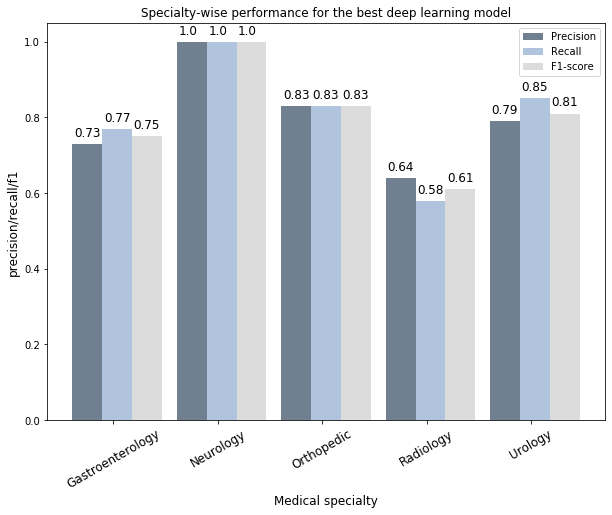

In [76]:
import matplotlib.pyplot as plt
label = ['Gastroenterology', 'Neurology', 'Orthopedic', 'Radiology',
       'Urology']
# Create bars
barWidth = 2
bars1 = [0.73, 1.0, 0.83, 0.64, 0.79]
bars2 = [0.77, 1.0, 0.83, 0.58 ,0.85]
bars3 = [0.75 , 1.0, 0.83, 0.61, 0.81]
bars4 = bars1 + bars2 + bars3
 
# The X position of bars
r1 = [1,8,15, 22, 29]
r2 = [3,10,17, 24, 31]
r3 = [5,12,19,26,33]
r4 = r1 + r2 + r3
 
plt.figure(figsize=(10, 1.2))
# Create barplot
plt.bar(r1, bars1, width = barWidth, color = 'slategrey', label='Precision')
plt.bar(r2, bars2, width = barWidth, color = 'lightsteelblue', label='Recall')
plt.bar(r3, bars3, width = barWidth, color = 'gainsboro', label='F1-score')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend()
plt.xlabel('Medical specialty', fontsize=12)
plt.ylabel('precision/recall/f1', fontsize=12)
 
# Text below each barplot with a rotation at 90°
#plt.xticks([r + barWidth for r in range(len(r4)/3)], ['DD', 'with himself', 'with DC', 'with Silur', 'DC'], rotation=90)
 
# Create labels
labels = bars4
 
# Text on the top of each barplot
for i in range(len(r4)):
    plt.text(x = r4[i]-0.9 , y = bars4[i]+0.02, s = labels[i], size = 12, rotation = 0)
 
# Adjust the margins
plt.subplots_adjust(bottom=1, top = 5.6)
#X = np.arange(15)
plt.title('Specialty-wise performance for the best deep learning model')
plt.xticks([2.75, 9.75, 16.75, 23.75, 30.75], label, fontsize=12, rotation=30)
# Show graphic
plt.show()